# Autoregressive Temperature Prediction Demo

This notebook demonstrates multi-step autoregressive prediction using the trained CNN-LSTM model.

**Approach:**
1. Load the trained model from `runs/2025-11-19_18-49-53/checkpoints/best_model.pt`
2. Load ground truth frames from the test dataset
3. Use first 3 frames as initial context
4. Predict frame 4 using frames [1, 2, 3]
5. Predict frame 5 using frames [2, 3, 4_predicted]
6. Compare predictions vs ground truth and visualize error accumulation

**Note:** Limited to 5 total frames (3 context + 2 predictions) due to test set size constraints.

In [1]:
import torch
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import json

# Add project root to path
project_root = Path("../").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from lasernet.model.CNN_LSTM import CNN_LSTM
from lasernet.dataset import SliceSequenceDataset

data_dir = os.environ['BLACKHOLE']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Load Trained Model

In [ ]:
# Load checkpoint
run_dir = Path("../runs/2025-11-19_18-49-53/")
checkpoint = torch.load(run_dir / "checkpoints" / "best_model.pt", map_location=device)
config = json.loads((run_dir / "config.json").read_text())

print("Checkpoint contents:")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Train loss: {checkpoint['train_loss']:.4f}")
print(f"  Val loss: {checkpoint['val_loss']:.4f}")
print(f"  split_ratio: {config['dataset']['train_sequences']}") # Todo

# Initialize model with same architecture
model = CNN_LSTM(
    input_channels=1,
    hidden_channels=[16, 32, 64],
    lstm_hidden=64,
    lstm_layers=1,
    temp_min=300.0,
    temp_max=2000.0,
).to(device)

# Load trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Model loaded successfully!")
print(f"  Parameters: {model.count_parameters():,}")

Checkpoint contents:
  Epoch: 83
  Train loss: 886.1565
  Val loss: 2306.0069
  split_ratio: 10
Model loaded successfully!
  Parameters: 344,065


## 2. Load Test Dataset

We'll load a sequence of frames from the test set to use as ground truth.

In [8]:
# Load test dataset (using same configuration as training)
test_dataset = SliceSequenceDataset(
    field="temperature",
    plane="xz",
    split="test",
    sequence_length=3,
    target_offset=1,
    preload=False,  # Faster for demo
    train_ratio=12/24,
    val_ratio=6/24,
    test_ratio=6/24,
)

print(f"Test dataset loaded:")
print(f"  Total samples: {len(test_dataset)}")
print(f"  Valid sequences: {test_dataset.num_valid_sequences}")
print(f"  Slices per timestep: {len(test_dataset.slice_coords)}")
print()

# Get first sample to check dimensions
sample = test_dataset[0]
print(f"Sample dimensions:")
print(f"  Context: {sample['context'].shape}")
print(f"  Target: {sample['target'].shape}")
print(f"  Timesteps: {sample['timestep_start']} -> {sample['target_timestep']}")

Test dataset loaded:
  Total samples: 188
  Valid sequences: 2
  Slices per timestep: 94

Sample dimensions:
  Context: torch.Size([3, 1, 47, 465])
  Target: torch.Size([1, 47, 465])
  Timesteps: 0 -> 4


## 3. Prepare Ground Truth Sequence

We need to extract consecutive frames from the same slice coordinate to form a continuous sequence.

In [12]:
num_initial_frames = 3   # Use first 3 frames as context (matches sequence_length)
num_predictions = 3      # Predict next 3 frames autoregressively (limited by test set size)
total_frames_needed = num_initial_frames + num_predictions

print(f"Loading {total_frames_needed} consecutive frames...")
print(f"Test set has {test_dataset.num_valid_sequences} valid sequences")

# Load temperature data directly from preprocessed file
import os
data_dir = os.environ['BLACKHOLE']
temp_path = os.path.join(data_dir, 'processed', 'temperature.pt')

if os.path.exists(temp_path):
    print(f"Loading from preprocessed file: {temp_path}")
    temp_data = torch.load(temp_path, map_location='cpu')  # [T, X, Y, Z]
    print(f"Temperature data shape: {temp_data.shape}")
    
    # Get test timestep range
    num_timesteps = temp_data.shape[0]
    test_start_idx = int((12/24) * num_timesteps) + int((6/24) * num_timesteps)
    test_end_idx = num_timesteps
    
    print(f"Test timesteps: {test_start_idx} to {test_end_idx-1}")
    print(f"Available test timesteps: {test_end_idx - test_start_idx}")
    
    # Extract XZ slice (same plane as training)
    # For XZ plane, we iterate over Y coordinates
    slice_idx = temp_data.shape[2] // 2  # Middle Y coordinate
    
    # Get consecutive frames
    ground_truth_frames = []
    for t_idx in range(test_start_idx, min(test_start_idx + total_frames_needed, test_end_idx)):
        # Extract XZ slice at this timestep [X, Z]
        slice_2d = temp_data[t_idx, :, slice_idx, :]  # [X, Z]
        
        # Downsample by factor of 2 (same as dataset)
        slice_2d = slice_2d[::2, ::2]
        
        # Add channel dimension [1, X, Z]
        slice_2d = slice_2d.unsqueeze(0)
        ground_truth_frames.append(slice_2d)
    
    # Stack into tensor [T, 1, X, Z]
    ground_truth = torch.stack(ground_truth_frames, dim=0)
    
    print(f"\nGround truth sequence shape: {ground_truth.shape}")
    print(f"Temperature range: [{ground_truth.min():.1f}, {ground_truth.max():.1f}] K")
    print(f"Frames loaded: {len(ground_truth_frames)}")
    
else:
    print(f"ERROR: Preprocessed file not found at {temp_path}")
    print("Please run scripts/preprocess_data.py first!")
    raise FileNotFoundError(f"Missing {temp_path}")

Loading 6 consecutive frames...
Test set has 2 valid sequences
Loading from preprocessed file: /dtu/blackhole/06/168550/processed/temperature.pt
Temperature data shape: torch.Size([24, 465, 94, 47])
Test timesteps: 18 to 23
Available test timesteps: 6

Ground truth sequence shape: torch.Size([6, 1, 233, 24])
Temperature range: [300.0, 4649.0] K
Frames loaded: 6


## 4. Autoregressive Prediction

Use the first 3 frames as initial context, then predict frames 4-5 autoregressively:
- Frame 4: predict using frames [1, 2, 3]
- Frame 5: predict using frames [2, 3, 4_pred]

In [ ]:
# Initialize predictions list with ground truth initial frames
predictions = [ground_truth[i] for i in range(num_initial_frames)]

print(f"Starting autoregressive prediction...")
print(f"Initial frames: 0-{num_initial_frames-1}")
print(f"Predicting frames: {num_initial_frames}-{num_initial_frames + num_predictions - 1}")
print()

model.eval()
with torch.no_grad():
    for step in range(num_predictions):
        # Get last 3 frames as input (sequence_length=3)
        input_frames = predictions[-3:]  # List of 3 tensors [1, H, W]
        input_seq = torch.stack(input_frames, dim=0)  # [3, 1, H, W]
        
        # Add batch dimension and move to device
        input_batch = input_seq.unsqueeze(0).to(device)  # [1, 3, 1, H, W]
        
        # Predict next frame
        pred = model(input_batch)  # [1, 1, H, W]
        
        # Remove batch dimension and move to CPU
        pred_frame = pred.squeeze(0).cpu()  # [1, H, W]
        
        # Append to predictions
        predictions.append(pred_frame)
        
        frame_idx = num_initial_frames + step
        gt_frame = ground_truth[frame_idx]
        mse = ((pred_frame - gt_frame) ** 2).mean().item()
        mae = (pred_frame - gt_frame).abs().mean().item()
        
        print(f"Frame {frame_idx}: MSE = {mse:.2f} K², MAE = {mae:.2f} K")

# Stack predictions into tensor [T, 1, H, W]
predictions_tensor = torch.stack(predictions, dim=0)

print()
print(f"Predicted sequence shape: {predictions_tensor.shape}")

Starting autoregressive prediction...
Initial frames: 0-2
Predicting frames: 3-5

Frame 3: MSE = 91872.49 K², MAE = 163.97 K
Frame 4: MSE = 148663.34 K², MAE = 232.19 K
Frame 5: MSE = 220297.02 K², MAE = 301.33 K

Predictions complete!
Predicted sequence shape: torch.Size([6, 1, 233, 24])


## 5. Visualize Results

Plot ground truth, predictions, and error for all frames.

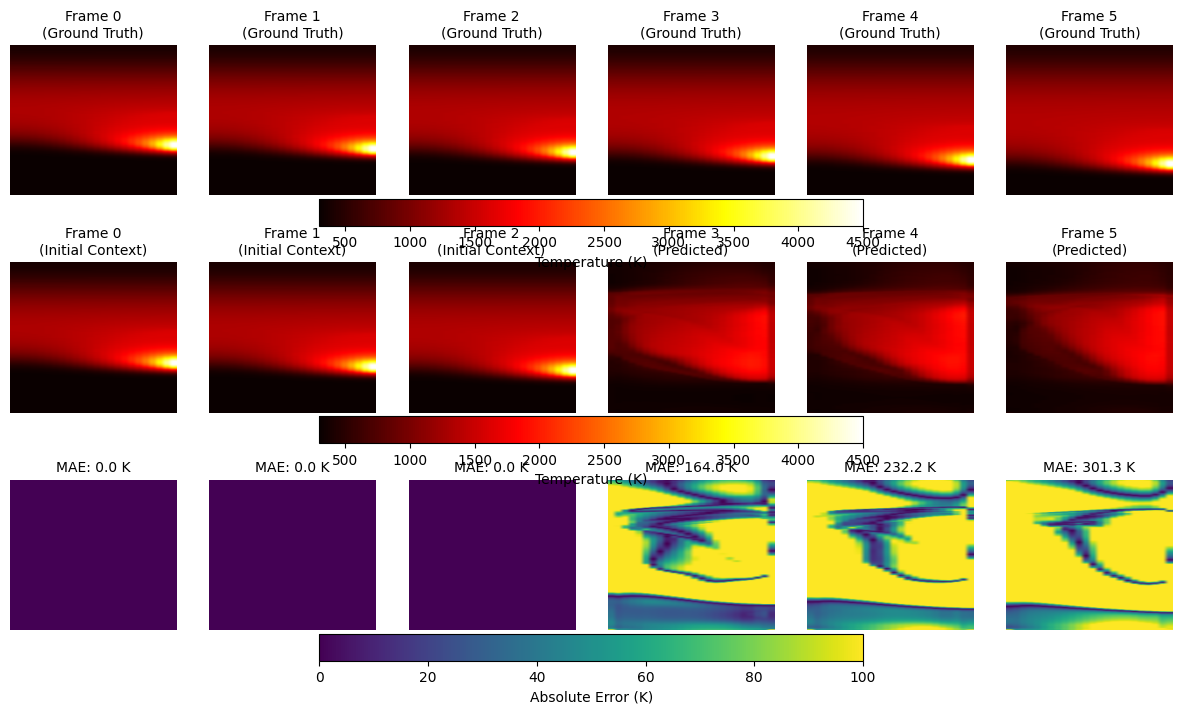

Visualization saved to: ../runs/2025-11-19_18-49-53/visualizations/autoregressive_prediction.png


In [21]:
# Create figure with 3 rows: ground truth, predictions, absolute error
num_frames_to_plot = total_frames_needed
fig, axes = plt.subplots(3, num_frames_to_plot, figsize=(2.5 * num_frames_to_plot, 8))

cmap = colormaps['hot']
vmin, vmax = 300, 4500  # Temperature range in Kelvin

for i in range(num_frames_to_plot):
    # Ground truth
    gt = ground_truth[i, 0].cpu().numpy()  # [H, W]
    im0 = axes[0, i].imshow(gt, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
    axes[0, i].set_title(f"Frame {i}\n(Ground Truth)", fontsize=10)
    axes[0, i].axis('off')
    
    # Prediction
    pred = predictions_tensor[i, 0].cpu().numpy()  # [H, W]
    im1 = axes[1, i].imshow(pred, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
    
    if i < num_initial_frames:
        axes[1, i].set_title(f"Frame {i}\n(Initial Context)", fontsize=10)
    else:
        axes[1, i].set_title(f"Frame {i}\n(Predicted)", fontsize=10)
    axes[1, i].axis('off')
    
    # Absolute error
    error = np.abs(pred - gt)
    im2 = axes[2, i].imshow(error, cmap='viridis', vmin=0, vmax=100, aspect='auto')
    mae = error.mean()
    axes[2, i].set_title(f"MAE: {mae:.1f} K", fontsize=10)
    axes[2, i].axis('off')

# Add colorbars
fig.colorbar(im0, ax=axes[0, :], orientation='horizontal', pad=0.02, label='Temperature (K)')
fig.colorbar(im1, ax=axes[1, :], orientation='horizontal', pad=0.02, label='Temperature (K)')
fig.colorbar(im2, ax=axes[2, :], orientation='horizontal', pad=0.02, label='Absolute Error (K)')

#plt.tight_layout()
#plt.savefig('../runs/2025-11-19_18-49-53/visualizations/autoregressive_prediction.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to: ../runs/2025-11-19_18-49-53/visualizations/autoregressive_prediction.png")

## 6. Error Analysis

Analyze how error accumulates during autoregressive prediction.

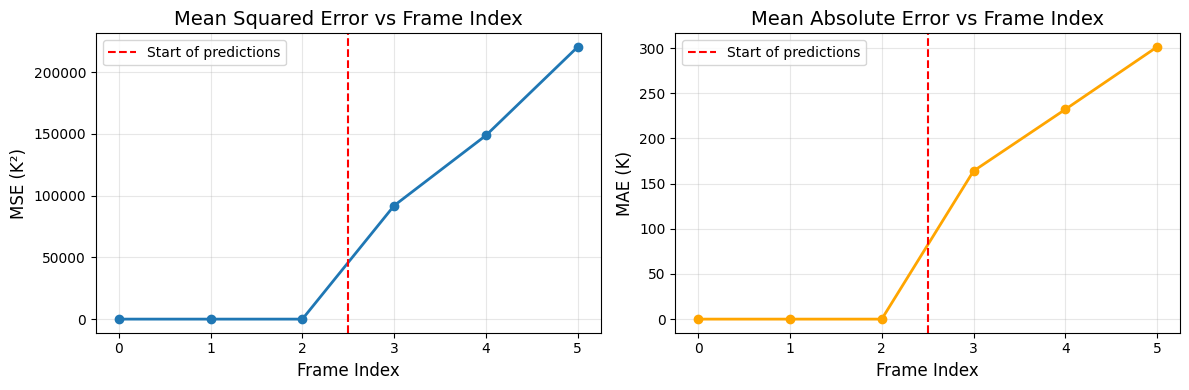


Error Statistics:
  Initial context (frames 0-2): MAE = 0.00 K (should be ~0)
  Predicted frames (3-5): MAE = 232.50 K
  Error increase per step: 45.79 K/step


In [15]:
# Calculate metrics for each frame
mse_per_frame = []
mae_per_frame = []

for i in range(total_frames_needed):
    gt = ground_truth[i, 0]
    pred = predictions_tensor[i, 0]
    
    mse = ((pred - gt) ** 2).mean().item()
    mae = (pred - gt).abs().mean().item()
    
    mse_per_frame.append(mse)
    mae_per_frame.append(mae)

# Plot error evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# MSE plot
ax1.plot(range(total_frames_needed), mse_per_frame, marker='o', linewidth=2)
ax1.axvline(x=num_initial_frames - 0.5, color='red', linestyle='--', label='Start of predictions')
ax1.set_xlabel('Frame Index', fontsize=12)
ax1.set_ylabel('MSE (K²)', fontsize=12)
ax1.set_title('Mean Squared Error vs Frame Index', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# MAE plot
ax2.plot(range(total_frames_needed), mae_per_frame, marker='o', linewidth=2, color='orange')
ax2.axvline(x=num_initial_frames - 0.5, color='red', linestyle='--', label='Start of predictions')
ax2.set_xlabel('Frame Index', fontsize=12)
ax2.set_ylabel('MAE (K)', fontsize=12)
ax2.set_title('Mean Absolute Error vs Frame Index', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('../runs/2025-11-19_18-49-53/visualizations/error_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nError Statistics:")
print(f"  Initial context (frames 0-{num_initial_frames-1}): MAE = {np.mean(mae_per_frame[:num_initial_frames]):.2f} K (should be ~0)")
print(f"  Predicted frames ({num_initial_frames}-{total_frames_needed-1}): MAE = {np.mean(mae_per_frame[num_initial_frames:]):.2f} K")
print(f"  Error increase per step: {(mae_per_frame[-1] - mae_per_frame[num_initial_frames]) / num_predictions:.2f} K/step")